# TTP Machine Learning Project - AMES Housing Dataset

<p><a name="sections"></a></p>


## Sections

- <a href="#GLM">Generalized Linear Models</a><br>
    - <a href="#function_def">Function and Class Definitions</a><br>
    - <a href="#data_prep">Data Preperation</a><br>
        - <a href="#dist">Price Distribution</a><br>
    - <a href="#lasso">Lasso</a><br>
        - <a href="#data_vis_las">Data Visualization</a><br>
        - <a href="#fi_las">Reduced Features</a><br>
    - <a href="#elastic_net">Elastic Net</a><br>
        - <a href="#data_vis_en">Data Visualization Elastic Net</a><br>
    
    - <a href="#xgboo">XG Boost</a><br>
        - <a href="#data_vis_xg">Data Visualization XGBoost</a><br>
        - <a href="#fi_xg">Feature Importance</a><br>
    - <a href="#ran_for">Random Forest</a><br>
    - <a href="#sim_stack">Stacking</a><br>
    - <a href="#sub">Submissions</a><br>

### Import Packages

In [187]:
#!pip install mlxtend

In [194]:
#!pip install xgboost

In [255]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
import sklearn.model_selection as ms
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

<p><a name="function_def"></a></p>

## Function and Class Definitions


In [2]:
def printErrors(Yt, predMod):
    """
    This function takes the following inputs:
    1. Yt = the trained predicted values
    2. predMod = the prediction from the fitted model
    It thens prints the errors for the model ie MAE, MSE, RMSLE
    """
    errors = abs(np.expm1(predMod) - np.expm1(Yt))
    print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
    print('Mean Squared Error (MSE):', mean_squared_error(Yt, predMod))
    print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(Yt, predMod)))
    print('Root Mean Square Log Error (RMSLE):', np.sqrt(mean_squared_log_error(Yt, predMod)))
    mape = 100 * (errors / np.expm1(Yt))
    print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

In [3]:
def printMod(Xtr,Xte,Ytr, Yte, modSel, modName):
    """
    This function takes the following inputs:
    1. Xtr,Xte,Ytr,Yte = X train data set, X test data set, Y train array, Y test array
    2. modSel is the fitted model
    3. modName is the model name used for plotting i.e. OLS, Lasso, Random Forest
    It then creates a plot for test vs train predicted prices
    """
    y_train_eNet = modSel.predict(Xtr)
    y_test_eNet = modSel.predict(Xte)
    # Plot predictions
    plt.figure(figsize=(12,8))
    plt.scatter(np.expm1(y_train_eNet), np.expm1(Ytr), c='black', marker="o", s=15, label = "Training data")
    plt.scatter(np.expm1(y_test_eNet), np.expm1(Yte), c='orange', marker='o', s=15, label = "Test data")
    plt.title(modName + " Model Train vs Test", fontsize = 20)
    plt.xlabel("Predicted Prices", fontsize = 16)
    plt.ylabel("Actual Prices", fontsize = 16)
    plt.xlim(0, 800000)
    plt.ylim(0, 800000)
    plt.legend(loc = "upper left")
    plt.plot([0, 800000], [0, 800000], c = "grey")
    plt.show()

In [249]:
def predictTocsv(modSel,df, title):
    """
    Function takes selected model and creates CSV file
    Function takes two inputs:
    1. modSel = selected model used to create predictions
    2. title = title for CSV
    """
    pred = modSel.predict(df)
    pred = np.expm1(predEnet)
    ids = np.arange(1461,2920,1)
    predfin = pd.DataFrame({'Id':ids,'SalePrice': pred})
    predfin.to_csv(title + '.csv', index=False)

In [ ]:
def rmse_stack(model):
    """
    Perform kfold cross validation on stack model
    k = 5
    """
    kf = KFold(n_splits = 5, shuffle=True, random_state=20).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, np.array(X_train), Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

<p><a name="data_prep"></a></p>

## Data Preperation

In [171]:
kfo = KFold(n_splits=5,shuffle = True, random_state = 32)

#### Import Cleaned Data and split into Test and Train

In [393]:
#change file name for import here
fileName = "try7"

In [394]:
trainDFNew = pd.read_csv(fileName + '.csv', index_col = 0)

In [395]:
X_n = trainDFNew.loc[:,trainDFNew.columns != 'ylogSalePrice'].copy()

In [396]:
Y_n = trainDFNew['ylogSalePrice'].reset_index(drop=True)

In [397]:
print('train', X_n.shape, 'y', Y_n.shape)

train (1456, 287) y (1456,)


In [398]:
X_train,X_test, Y_train,Y_test = train_test_split(X_n,Y_n, test_size = 0.3, random_state=31)

In [399]:
print('train', X_test.shape, 'y', X_train.shape)

train (437, 287) y (1019, 287)


##### Check distribution of sale price after log transformation

(array([  3.,   2.,   0.,   0.,   2.,   3.,   6.,   6.,   3.,  18.,  33.,
         30.,  36.,  80.,  93., 135., 156., 118., 128., 135.,  86.,  83.,
         75.,  60.,  49.,  37.,  27.,  16.,  15.,  10.,   4.,   1.,   4.,
          2.,   0.,   2.]),
 array([10.46027076, 10.54566531, 10.63105985, 10.71645439, 10.80184894,
        10.88724348, 10.97263803, 11.05803257, 11.14342711, 11.22882166,
        11.3142162 , 11.39961075, 11.48500529, 11.57039984, 11.65579438,
        11.74118892, 11.82658347, 11.91197801, 11.99737256, 12.0827671 ,
        12.16816165, 12.25355619, 12.33895073, 12.42434528, 12.50973982,
        12.59513437, 12.68052891, 12.76592345, 12.851318  , 12.93671254,
        13.02210709, 13.10750163, 13.19289618, 13.27829072, 13.36368526,
        13.44907981, 13.53447435]),
 <a list of 36 Patch objects>)

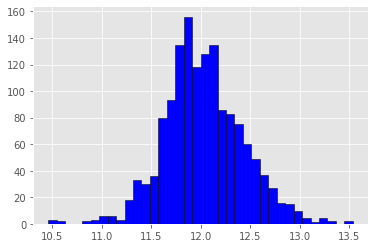

In [147]:
plt.hist(trainDFNew['ylogSalePrice'], color = 'blue', edgecolor = 'black', bins = int(180/5))


Text(0.5, 1.0, 'Probplot against normal dist')

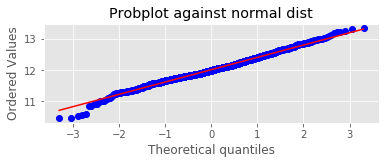

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(trainDFNew['ylogSalePrice'], dist=stats.norm,plot = ax1)
ax1.set_xlabel = ''
ax1.set_title('Probplot against normal dist')


In [135]:
#X_train,X_test, Y_train,Y_test = train_test_split(X_n,Y_n, test_size = 0, random_state=0)

ValueError: test_size=0 should be either positive and smaller than the number of samples 1458 or a float in the (0, 1) range

In [32]:
print('train', X_train.shape, 'y', X_test.shape)

train (1019, 244) y (437, 244)


In [409]:
lasMod = linear_model.Lasso(normalize=True)
lasMod = lasMod.set_params(random_state = 28, tol = 0.0001)
#lasMod.fit(X_train,Y_train)
lasMod.fit(X_train,Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=28,
   selection='cyclic', tol=0.0001, warm_start=False)

In [402]:
#lasMod = make_pipeline(RobustScaler(),linear_model.Lasso(normalize=True, random_state = 28, tol = 0.000))
#lasMod = lasMod.set_params(random_state = 28, tol = 0.0001)
#lasMod.fit(X_train,Y_train)
#lasMod.fit(X_train,Y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=28,
   selection='cyclic', tol=0.0, warm_start=False))])

<p><a name="lasso"></a></p>

## Lasso

In [410]:
lasso_pred = lasMod.predict(X_train)

In [411]:
printErrors(Y_train,lasso_pred)

Mean Absolute Error (MAE): $ 54856.96
Mean Squared Error (MSE): 0.1568088330950445
Root Mean Square Error (RMSE): 0.3959909507741869
Root Mean Square Log Error (RMSLE): 0.03039143052246651
Mean Absolute Percent Error (MAPE): 31.99 %.


In [412]:
#set range for alphas in cross validation and set parameter grid for gridsearch cv 
#note iteration parameters very sensitive for convergence, needed to increase
alphaRange = 100**np.linspace(10,-2,1000)*0.5
param_grid_lasso = {"max_iter": [500, 1000, 1500],
                     "alpha": alphaRange}

In [142]:
def rmse_cv(model):
    kf = KFold(n_splits = 5, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [143]:
rmse_cv(lasMod)

array([0.38345776, 0.38048712, 0.4013255 , 0.41107391, 0.40430592])

In [413]:
#played with Kfo = 5 and 10, 10 performs better
grid_search_lasso = ms.GridSearchCV(lasMod, param_grid_lasso, scoring= 'neg_mean_squared_error', 
                                    cv= kfo, n_jobs=-1, return_train_score = True)




In [414]:
%time grid_search_lasso.fit(X_train, Y_train)

Wall time: 2min 25s


GridSearchCV(cv=KFold(n_splits=5, random_state=32, shuffle=True),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=28,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_iter': [500, 1000, 1500], 'alpha': array([5.00000e+19, 4.73092e+19, ..., 5.28438e-05, 5.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [415]:
grid_search_lasso.best_params_

{'alpha': 8.693812001081253e-05, 'max_iter': 500}

In [416]:
grid_lasso = grid_search_lasso.best_estimator_

In [417]:
print("The train set R^2 is: %.5f" % grid_lasso.score(X_train, Y_train))
print("The test set R^2 is is: %.5f" % grid_lasso.score(X_test, Y_test))

The train set R^2 is: 0.94703
The test set R^2 is is: 0.90006


In [418]:
#Prediction with tuned hyperparameters
grid_lasso_pred = grid_lasso.predict(X_test)
printErrors(Y_test,grid_lasso_pred)

Mean Absolute Error (MAE): $ 13535.59
Mean Squared Error (MSE): 0.015620883390384427
Root Mean Square Error (RMSE): 0.12498353247682042
Root Mean Square Log Error (RMSLE): 0.009870708974745592
Mean Absolute Percent Error (MAPE): 8.26 %.


<p><a name="data_vis_las"></a></p>

### Lasso Data Visualization

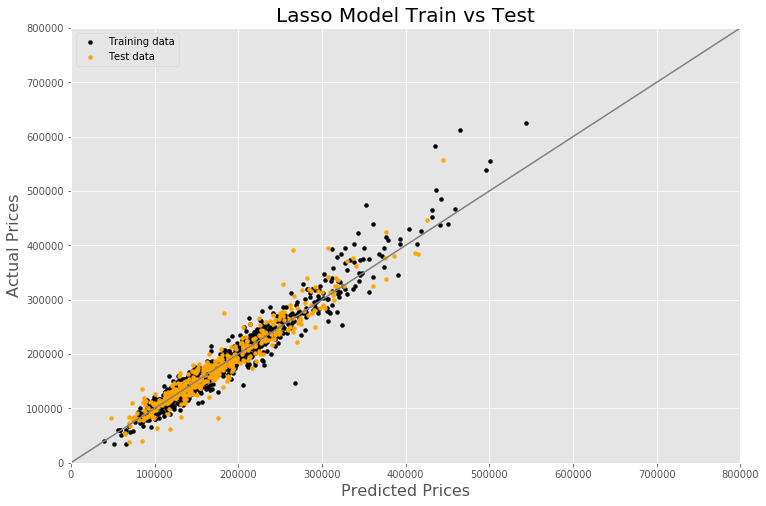

In [419]:
printMod(X_train,X_test,Y_train,Y_test,grid_lasso,"Lasso")

<p><a name="fi_las"></a></p>

### Lasso Feature Importance

In [420]:
coeff = pd.DataFrame({"feature":X_train.columns,"coeff":grid_lasso.coef_})
coeff = coeff.sort_values(by = 'coeff', ascending = False)

print(coeff[coeff.coeff!=0].shape)
mod_=coeff[coeff.coeff!=0]
mod_

(111, 2)


,feature,coeff
37,Street_Pave,0.267192
61,Condition2_PosA,0.100974
24,TotalSF,0.099275
207,SaleType_New,0.088355
136,BsmtQual_No,0.071090
87,RoofMatl_WdShngl,0.070322
12,GrLivArea,0.066679
28,Percent_BsmtF,0.064688
90,Exterior1st_BrkFace,0.061839
166,CentralAir_Y,0.060316


In [421]:
dfList = mod_['feature'].tolist()

In [422]:
dfList

['Street_Pave',
 'Condition2_PosA',
 'TotalSF',
 'SaleType_New',
 'BsmtQual_No',
 'RoofMatl_WdShngl',
 'GrLivArea',
 'Percent_BsmtF',
 'Exterior1st_BrkFace',
 'CentralAir_Y',
 'MSZoning_FV',
 'Functional_Typ',
 'BsmtExposure_Gd',
 'OverallQual',
 'Condition1_Norm',
 'SaleCondition_Normal',
 'Condition1_PosN',
 'GarageCars',
 'OverallCond',
 'Heating_Wall',
 'MSZoning_RL',
 'Foundation_Stone',
 'MasVnrType_Stone',
 'Fireplaces',
 'LotArea',
 'TotalBath',
 'PavedDrive_Y',
 'CrawforQual',
 'LotConfig_CulDSac',
 'Foundation_PConc',
 'FireplaceQu_Po',
 'NridgHtQual',
 'Neighborhood_ClearCr',
 'NoRidgeQual',
 'LotShape_IR2',
 'ExterCond_TA',
 'LandSlope_Mod',
 'GarageType_BuiltIn',
 'BrkSideQual',
 'Neighborhood_SWISU',
 'Exterior2nd_CmentBd',
 'BsmtFinType1_GLQ',
 'StoneBrQual',
 'StoneBrSF',
 'GarageArea',
 'RoofStyle_Mansard',
 'TotalPorchSF',
 'BsmtCond_No',
 'YearBuilt',
 'HouseStyle_1.5Unf',
 'Exterior2nd_VinylSd',
 'SomerstSF',
 'Heating_GasW',
 'BsmtFinSF1',
 'totNewcity',
 'BsmtFinT

In [423]:
coefs_lasso  = []

for alpha in alphaRange:
        grid_lasso.set_params(alpha=alpha)
        grid_lasso.fit(X_train, Y_train)  
        coefs_lasso.append(grid_lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphaRange, columns = X_train.columns)  
coefs_lasso.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,TimberQual,NoRidgeQual,StoneBrQual,SWISUQual,ClearCrQual,MeadowVQual,BrDaleual,VeenkerQual,NPkVillQual,BluesteQual
5.000000e+19,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
4.730924e+19,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
4.476329e+19,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
4.235434e+19,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
4.007503e+19,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0


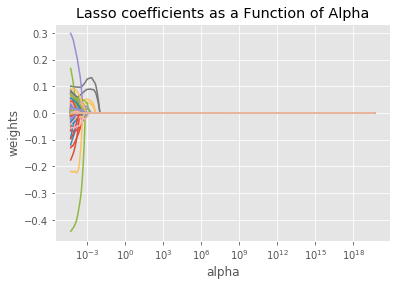

In [424]:
ax = plt.gca()

ax.plot(alphaRange, coefs_lasso)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a Function of Alpha')
plt.axis('tight')
plt.show()

<p><a name="elastic_net"></a></p>

## Elastic Net

In [425]:
eNet = linear_model.ElasticNet(normalize=True)
eNet = eNet.set_params(random_state = 42)

#fit baseline elastic net model on Train df
eNet.fit(X_train,Y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

In [426]:
# Initial prediction
eNet_pred = eNet.predict(X_test)

In [427]:
printErrors(Y_test,eNet_pred)

Mean Absolute Error (MAE): $ 54970.62
Mean Squared Error (MSE): 0.15683835587893585
Root Mean Square Error (RMSE): 0.3960282261139171
Root Mean Square Log Error (RMSLE): 0.03048574073025496
Mean Absolute Percent Error (MAPE): 32.46 %.


In [428]:
param_grid_eNet = {"max_iter": [500, 1000, 1500],
                    "alpha": 100**np.linspace(10,-2,1000)*0.5,
                    "l1_ratio": np.arange(0.0, 1.0, 0.1)}

In [429]:
grid_search_eNet = ms.GridSearchCV(eNet, param_grid_eNet, scoring= 'neg_mean_squared_error', 
                                   cv= kfo, n_jobs=-1, return_train_score = True)

%time grid_search_eNet.fit(X_train, Y_train)

Wall time: 1h 8min 53s


GridSearchCV(cv=KFold(n_splits=5, random_state=32, shuffle=True),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_iter': [500, 1000, 1500], 'alpha': array([5.00000e+19, 4.73092e+19, ..., 5.28438e-05, 5.00000e-05]), 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [430]:
grid_search_eNet.best_params_

{'alpha': 9.188281001940825e-05, 'l1_ratio': 0.9, 'max_iter': 500}

In [431]:
# Prediction using the tuned parameters
grid_eNet = grid_search_eNet.best_estimator_

In [432]:
print("Train R^2 is: %.5f" % grid_eNet.score(X_train, Y_train))
print("Test R^2 is is: %.5f" % grid_eNet.score(X_test, Y_test))

Train R^2 is: 0.94731
Test R^2 is is: 0.90014


In [433]:
#Prediction with tuned hyperparameters
grid_eNet_pred = grid_eNet.predict(X_test)

In [434]:
printErrors(Y_test,grid_eNet_pred)

Mean Absolute Error (MAE): $ 13531.47
Mean Squared Error (MSE): 0.015607711136357841
Root Mean Square Error (RMSE): 0.12493082540493296
Root Mean Square Log Error (RMSLE): 0.009865756287035406
Mean Absolute Percent Error (MAPE): 8.26 %.


<p><a name="data_vis_en"></a></p>

### Elastic Net Data Visualization

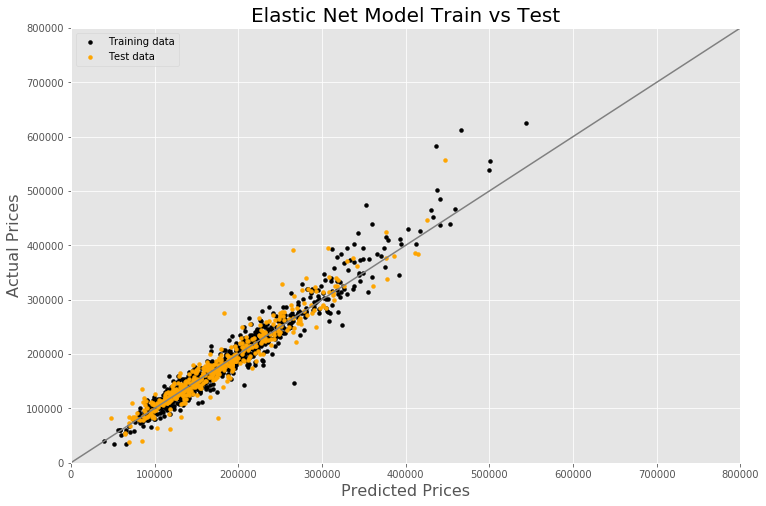

In [435]:
printMod(X_train,X_test,Y_train,Y_test,grid_eNet,"Elastic Net")

<p><a name="xgboo"></a></p>

## XGBoost

In [436]:
#initialize xgboost
xgb = XGBRegressor()
xgb.set_params(random_state=22,objective='reg:squarederror')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=22, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [437]:
xgb.fit(X_train, Y_train)

C:\Users\tnivo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=22, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [438]:
print("Train R^2 is: %.5f" % xgb.score(X_train, Y_train))
print("Test set R^2 is is: %.5f" % xgb.score(X_test, Y_test))

Train R^2 is: 0.96346
Test set R^2 is is: 0.88274


In [439]:
# Initial prediction
xgb_pred = xgb.predict(X_test)

In [440]:
printErrors(Y_test, xgb_pred)
#printErrors(Yt, predMod)

Mean Absolute Error (MAE): $ 15134.96
Mean Squared Error (MSE): 0.018328011138155322
Root Mean Square Error (RMSE): 0.1353809851425056
Root Mean Square Log Error (RMSLE): 0.010625307519090315
Mean Absolute Percent Error (MAPE): 9.14 %.


In [441]:
xgb_param_grid ={'learning_rate': [0.01, 0.05, 0.1],
                 'max_depth': [2, 3, 4, 5, 6],
                 'min_child_weight': [4, 5, 6],
                 'n_estimators': [400, 450, 500, 550, 600]}

grid_search_xgb = ms.GridSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)



In [447]:
%time grid_search_xgb.fit(X_train, Y_train)

C:\Users\tnivo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Wall time: 32min 46s


GridSearchCV(cv=KFold(n_splits=5, random_state=32, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=22, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [2, 3, 4, 5, 6], 'min_child_weight': [4, 5, 6], 'n_estimators': [400, 450, 500, 550, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [448]:
# get the best parameters
grid_search_xgb.best_params_

{'learning_rate': 0.05,
 'max_depth': 2,
 'min_child_weight': 6,
 'n_estimators': 600}

In [449]:
grid_xgb = grid_search_xgb.best_estimator_

In [450]:
print("The train set R^2 is: %.5f" % grid_xgb.score(X_train, Y_train))
print("The test set R^2 is is: %.5f" % grid_xgb.score(X_test, Y_test))

The train set R^2 is: 0.96725
The test set R^2 is is: 0.89357


In [451]:
#Prediction with tuned hyperparameters
grid_xgb_pred = grid_xgb.predict(X_test)

In [452]:
printErrors(Y_test, grid_xgb_pred)

Mean Absolute Error (MAE): $ 14110.76
Mean Squared Error (MSE): 0.016634601829289115
Root Mean Square Error (RMSE): 0.12897519850455402
Root Mean Square Log Error (RMSLE): 0.010140635500968019
Mean Absolute Percent Error (MAPE): 8.52 %.


In [453]:
xgb_param_grid1 ={'learning_rate': [0.01],
                 'max_depth': [3],
                 'min_child_weight': [0],
                 'n_estimators': [3460],
                 'subsample': [0.7],
                 'colsample_bytree' : [0.7],
                 'objective':['reg:squarederror'],
                 'nthread':[-1],
                 'scale_pos_weight':[1],
                 'seed':[27],
                 'reg_alpha': [0.00006]}
                 

grid_search_xgb1 = ms.GridSearchCV(xgb, xgb_param_grid1, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)



In [454]:
%time grid_search_xgb1.fit(X_train, Y_train)

C:\Users\tnivo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Wall time: 1min 16s


GridSearchCV(cv=KFold(n_splits=5, random_state=32, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=22, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01], 'max_depth': [3], 'min_child_weight': [0], 'n_estimators': [3460], 'subsample': [0.7], 'colsample_bytree': [0.7], 'objective': ['reg:squarederror'], 'nthread': [-1], 'scale_pos_weight': [1], 'seed': [27], 'reg_alpha': [6e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_er

In [455]:
grid_search_xgb1.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 0,
 'n_estimators': 3460,
 'nthread': -1,
 'objective': 'reg:squarederror',
 'reg_alpha': 6e-05,
 'scale_pos_weight': 1,
 'seed': 27,
 'subsample': 0.7}

In [456]:
grid_xgb1 = grid_search_xgb1.best_estimator_

In [457]:
print("The train set R^2 is: %.5f" % grid_xgb1.score(X_train, Y_train))
print("The test set R^2 is is: %.5f" % grid_xgb1.score(X_test, Y_test))

The train set R^2 is: 0.98957
The test set R^2 is is: 0.89546


<p><a name="data_vis_xg"></a></p>

### XGBoost Data Visualization

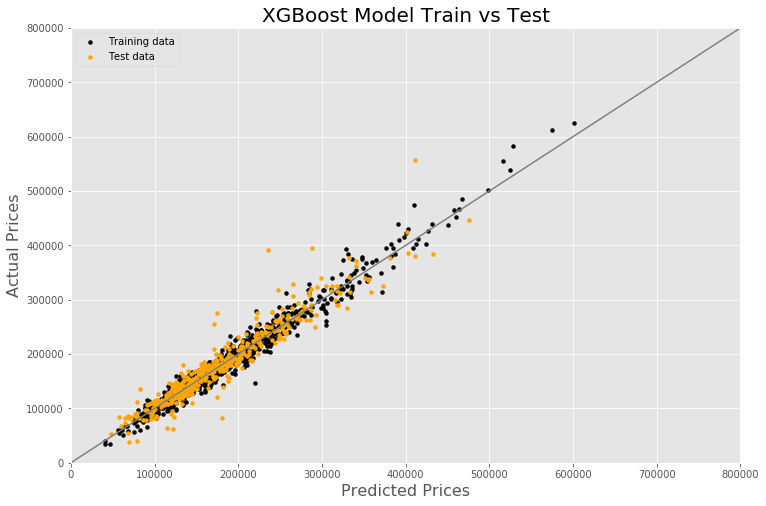

In [458]:
printMod(X_train,X_test,Y_train,Y_test,grid_xgb,"XGBoost")

In [459]:
# Get numerical feature importances
importances_xgb = list(xgb.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, importances_xgb)]

# Sort the feature importances by most important first
xgb_feature_importances = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in xgb_feature_importances]

Variable: GarageCars           Importance: 0.15929000079631805
Variable: OverallQual          Importance: 0.0914200022816658
Variable: TotalBath            Importance: 0.0715399980545044
Variable: Fireplaces           Importance: 0.06689000129699707
Variable: YearRemodAdd         Importance: 0.0654899999499321
Variable: TotalSF              Importance: 0.06441999971866608
Variable: KitchenQual_TA       Importance: 0.05186000093817711
Variable: GarageType_Attchd    Importance: 0.03164000064134598
Variable: CentralAir_Y         Importance: 0.029910000041127205
Variable: MSZoning_RL          Importance: 0.023590000346302986
Variable: MSZoning_RM          Importance: 0.023010000586509705
Variable: YearBuilt            Importance: 0.0210999995470047
Variable: YrSoldMinRem         Importance: 0.016739999875426292
Variable: GarageArea           Importance: 0.01408000010997057
Variable: PavedDrive_Y         Importance: 0.013500000350177288
Variable: BsmtExposure_Gd      Importance: 0.013310000

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<p><a name="fi_xg"></a></p>

### XGBoost Feature Importance

In [460]:
xgb_feature_importances_top20 = xgb_feature_importances[:20]
featureNames, featureScores = zip(*list(xgb_feature_importances_top20))
xgb_feature_importances_top20

[('GarageCars', 0.15929),
 ('OverallQual', 0.09142),
 ('TotalBath', 0.07154),
 ('Fireplaces', 0.06689),
 ('YearRemodAdd', 0.06549),
 ('TotalSF', 0.06442),
 ('KitchenQual_TA', 0.05186),
 ('GarageType_Attchd', 0.03164),
 ('CentralAir_Y', 0.02991),
 ('MSZoning_RL', 0.02359),
 ('MSZoning_RM', 0.02301),
 ('YearBuilt', 0.0211),
 ('YrSoldMinRem', 0.01674),
 ('GarageArea', 0.01408),
 ('PavedDrive_Y', 0.0135),
 ('BsmtExposure_Gd', 0.01331),
 ('OverallCond', 0.01075),
 ('GarageCond_TA', 0.01026),
 ('GarageYrBlt', 0.01008),
 ('BsmtFinSF1', 0.00923)]

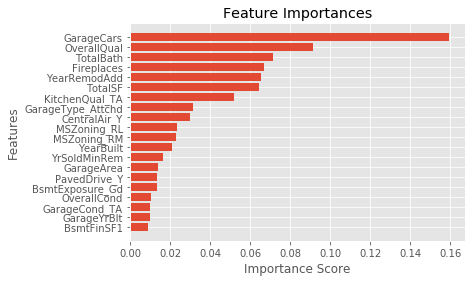

In [464]:
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')
plt.savefig('xgbFI.png')

In [465]:
xgb_params_tuned_model = grid_search_xgb.best_estimator_
xgb_feature_importance = 100.0 * (xgb_params_tuned_model.feature_importances_ / xgb_params_tuned_model.feature_importances_.max())
xgb_important_features = X_train.columns[xgb_feature_importance >= 2]
xgb_unimportant_features = X_train.columns[xgb_feature_importance < 2]

In [466]:
xgb_important_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'GrLivArea',
       'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'TotalSF', 'TotalBath', 'TotalPorchSF', 'Percent_BsmtF', 'YrSoldMinRem',
       'BsmtFin', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_Reg',
       'HouseStyle_2Story', 'Exterior1st_BrkFace', 'MasVnrType_Stone',
       'ExterCond_TA', 'BsmtQual_Gd', 'BsmtExposure_Gd', 'CentralAir_Y',
       'KitchenQual_TA', 'Functional_Typ', 'GarageType_Attchd',
       'GarageFinish_Unf', 'PavedDrive_Y', 'SaleType_New',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'totNewNeigh',
       'Neighborhood_Crawfor', 'Neighborhood_IDOTRR', 'Neighborhood_OldTown',
       'NAmesSF', 'EdwardsSF', 'CrawforSF', 'OldTownQual', 'SomerstQual'],
      dtype='object')

In [467]:
X_train_xgbreduced = X_train.drop(xgb_unimportant_features, axis=1)
X_test_xgbreduced = X_test.drop(xgb_unimportant_features, axis=1)

In [468]:
# GridSearchCV for multiple hyperparameters:
xgb=XGBRegressor()

xgb_param_grid ={'learning_rate': [0.05, 0.1, 0.15],
             'max_depth': [3, 4, 5],
             'n_estimators': [500, 1000, 2000]}

xgb.set_params(random_state=42)

grid_search_xgb2 = ms.GridSearchCV(xgb, xgb_param_grid, scoring= 'neg_mean_squared_error',
                           cv= kfo, n_jobs = 7, return_train_score=True, verbose = 1)
grid_search_xgb2.fit(X_train_xgbreduced, Y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   44.4s
[Parallel(n_jobs=7)]: Done 135 out of 135 | elapsed:  2.1min finished
C:\Users\tnivo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:04:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=32, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=7,
       param_grid={'learning_rate': [0.05, 0.1, 0.15], 'max_depth': [3, 4, 5], 'n_estimators': [500, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [469]:
predictions_tuned_xgb2 = grid_search_xgb2.best_estimator_.predict(X_test_xgbreduced)

In [470]:
printErrors(Y_test, predictions_tuned_xgb2)

Mean Absolute Error (MAE): $ 13986.98
Mean Squared Error (MSE): 0.017012884709177903
Root Mean Square Error (RMSE): 0.1304334493493824
Root Mean Square Log Error (RMSLE): 0.010254046544161682
Mean Absolute Percent Error (MAPE): 8.48 %.


<p><a name="ran_for"></a></p>

## Random Forest

In [471]:
#initialize RF model
#default n estimators = 10 will be deprecated and changed to 100 by default in new version .22, 
#set parameter n_estimators to 10
rforest = RandomForestRegressor()

rforest.set_params(random_state=52,n_estimators=10,)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=False)

In [472]:
#fit model on train data set
rforest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=False)

In [473]:
#find R2 of model on train and test data sets
print("The train set R^2 is: %.5f" % rforest.score(X_train, Y_train))
print("The test set R^2 is is: %.5f" % rforest.score(X_test, Y_test))

The train set R^2 is: 0.97579
The test set R^2 is is: 0.83772


This fit is the widest gap of all models. Random forest overfits on the test training set. Need to tune parameters

In [474]:
# Initial prediction
rforest_pred = rforest.predict(X_test)

In [475]:
printErrors(Y_test, rforest_pred)

Mean Absolute Error (MAE): $ 18569.61
Mean Squared Error (MSE): 0.02536417987608232
Root Mean Square Error (RMSE): 0.15926135713374515
Root Mean Square Log Error (RMSLE): 0.012441321319930365
Mean Absolute Percent Error (MAPE): 10.96 %.


MAE is not bad

In [476]:
# set parameter grid for kfold cross validation kfold is set above to 5
param_grid ={'max_depth': [20, 25, 30],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'min_samples_leaf':[1, 3, 5],
             'n_estimators': [500, 750, 1000, 1250, 1500]}

In [477]:
#test how different scoring impacts outcome...
grid_search_rforest = ms.GridSearchCV(rforest, param_grid, scoring='neg_mean_squared_error', 
                                     cv= kfo, n_jobs=-1, return_train_score = True)

In [478]:
%time grid_search_rforest.fit(X_train, Y_train)

Wall time: 1h 2min 9s


GridSearchCV(cv=KFold(n_splits=5, random_state=32, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [20, 25, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 3, 5], 'n_estimators': [500, 750, 1000, 1250, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [479]:
# get the best parameters
grid_search_rforest.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [480]:
# Prediction using the tuned parameters
grid_rforest = grid_search_rforest.best_estimator_

In [481]:
print("The train set R^2 is: %.5f" % grid_rforest.score(X_train, Y_train))
print("The test set R^2 is is: %.5f" % grid_rforest.score(X_test, Y_test))

The train set R^2 is: 0.98403
The test set R^2 is is: 0.85650


Even more over fit on the train data

In [482]:
#Prediction with tuned hyperparameters
grid_rforest_pred = grid_rforest.predict(X_test)

# Calculate the absolute errors
#errors = abs(np.expm1(grid_rforest_pred) - np.expm1(y_test))

# Print out MAE, MSE, and RMSE
#print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
#print('Mean Squared Error (MSE):', mean_squared_error(y_test, grid_rforest_pred))
#print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, grid_rforest_pred)))

# Calculate mean absolute percentage error (MAPE)
#mape = 100 * (errors / np.expm1(y_test))
#print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')


In [483]:
printErrors(Y_test, grid_rforest_pred)

Mean Absolute Error (MAE): $ 16792.78
Mean Squared Error (MSE): 0.022428691623270287
Root Mean Square Error (RMSE): 0.14976211678281756
Root Mean Square Log Error (RMSLE): 0.011717997184920257
Mean Absolute Percent Error (MAPE): 10.0 %.


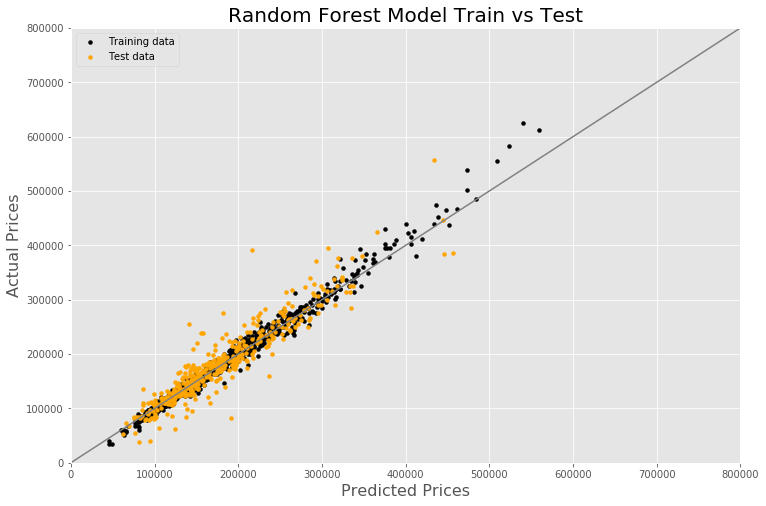

In [484]:
printMod(X_train,X_test,Y_train,Y_test,grid_rforest,"Random Forest")

In [485]:
# Random Forest Feature Importance 
# Get numerical feature importances
feats_rf = list(rforest.feature_importances_)

# List of tuples with variable and importance
feats_rf_score = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, feats_rf)]

# Sort the feature importances by most important first
sorted_feats_rf_score = sorted(feats_rf_score, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in sorted_feats_rf_score]

Variable: OverallQual          Importance: 0.49358
Variable: TotalSF              Importance: 0.27131
Variable: CentralAir_Y         Importance: 0.01866
Variable: GrLivArea            Importance: 0.01715
Variable: GarageArea           Importance: 0.01337
Variable: YearBuilt            Importance: 0.01287
Variable: YearRemodAdd         Importance: 0.0123
Variable: TotalBath            Importance: 0.01225
Variable: LotArea              Importance: 0.01209
Variable: BsmtFinSF1           Importance: 0.0103
Variable: YrSoldMinRem         Importance: 0.00745
Variable: BsmtUnfSF            Importance: 0.00622
Variable: TotalPorchSF         Importance: 0.0061
Variable: OverallCond          Importance: 0.0055
Variable: GarageQual_TA        Importance: 0.00521
Variable: GarageYrBlt          Importance: 0.00509
Variable: Percent_BsmtF        Importance: 0.00492
Variable: MSZoning_RM          Importance: 0.00491
Variable: GarageType_Detchd    Importance: 0.00449
Variable: PavedDrive_Y         Impo

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Text(0.5, 1.0, 'Feature Importances')

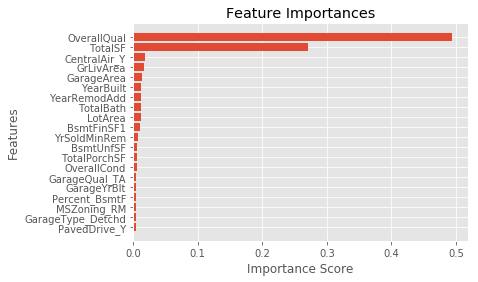

In [486]:
rf_feature_importances_top20 = sorted_feats_rf_score[:20]
featureNames, featureScores = zip(*list(rf_feature_importances_top20))

plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')

In [488]:
grid_rforest = grid_search_rforest.best_estimator_
feature_importance = 100.0 * (grid_rforest.feature_importances_ / grid_rforest.feature_importances_.max())
important_features = X_train.columns[feature_importance >= 0.0]
unimportant_features = X_train.columns[feature_importance < 0.0]

In [489]:
X_train_reduced = X_train.drop(unimportant_features, axis=1)
X_test_reduced = X_test.drop(unimportant_features, axis=1)

In [490]:
# GridSearchCV for multiple hyperparameters:
rForest_feats = RandomForestRegressor()

param_grid ={'max_depth': [10, 20, 30, 40, 50],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'n_estimators': [100, 300, 500, 800]}

rForest_feats.set_params(random_state=42)

grid_search_rForest2 = ms.GridSearchCV(rForest_feats, param_grid, scoring= 'neg_mean_squared_error',
                           cv= kfo, n_jobs = -1, return_train_score=True, verbose = 1)
grid_search_rForest2.fit(X_train_reduced, Y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 15.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=32, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30, 40, 50], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 3, 4], 'n_estimators': [100, 300, 500, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# GridSearchCV for multiple hyperparameters:
rForest_feats = RandomForestRegressor()

param_grid ={'max_depth': [10, 20, 30, 40, 50],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'n_estimators': [100, 300, 500, 800]}

rForest_feats.set_params(random_state=42)

grid_search_rForest2 = ms.GridSearchCV(rForest_feats, param_grid, scoring= 'neg_mean_squared_error',
                           cv= kfo, n_jobs = -1, return_train_score=True, verbose = 1)
grid_search_rForest2.fit(X_train_reduced, Y_train)# GridSearchCV for multiple hyperparameters:
rForest_feats = RandomForestRegressor()

param_grid ={'max_depth': [10, 20, 30, 40, 50],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'n_estimators': [100, 300, 500, 800]}

rForest_feats.set_params(random_state=42)

grid_search_rForest2 = ms.GridSearchCV(rForest_feats, param_grid, scoring= 'neg_mean_squared_error',
                           cv= kfo, n_jobs = -1, return_train_score=True, verbose = 1)
grid_search_rForest2.fit(X_train_reduced, Y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 14.8min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.3min


In [348]:
# get the best parameters
grid_search_rForest2.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 800}

In [349]:
# Use the forest's predict method on the test data
predictions_tuned_rForest2 = grid_search_rForest2.best_estimator_.predict(X_test_reduced)

# Calculate the absolute errors
errors = abs(np.expm1(predictions_tuned_rForest2) - np.expm1(Y_test))

# Print out the mean absolute error (MAE)
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('MSE:', mean_squared_error(Y_test, predictions_tuned_rForest2))
print('RMSE:', np.sqrt(mean_squared_error(Y_test, predictions_tuned_rForest2)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(Y_test))

# Calculate and display MAPE
#accuracy = 100 - np.mean(mape)
print('MAPE:', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 16704.88
MSE: 0.022159477981654564
RMSE: 0.14886059915791877
MAPE: 10.0 %.


<p><a name="sim_stack"></a></p>

## Stacking

In [307]:
stackMod = StackingCVRegressor(regressors=(grid_lasso,grid_eNet,grid_xgb,grid_rforest),
                              meta_regressor = grid_xgb, shuffle = True,
                              random_state = 20,
                              use_features_in_secondary= True)

In [308]:
%time stackMod.fit(X_train,Y_train)

Wall time: 57 s


StackingCVRegressor(cv=5,
          meta_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=6, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=22, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
          n_jobs=None, pre_dispatch='2*n_jobs', random_state=20,
          refit=True,
          regressors=(Lasso(alpha=5e-05, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, positive=False, precompute=False, random_state=28,
   selection='cyclic', tol=0.0001, warm_start=False), ElasticNet(alpha=0.00010263188763546239, copy_X=True, fit_intercept=True,
      l1_ratio=0.9, max_...imators=500, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=F

In [310]:
print("Train R^2: %.5f" % stackMod.score(np.array(X_train), np.array(Y_train)))
print("Test R^2: %.5f" % stackMod.score(np.array(X_test), np.array(Y_test)))

Train R^2: 0.97401
Test R^2: 0.89806


In [316]:
# Initial prediction
stackMod_pred = stackMod.predict(np.array(X_test))

In [317]:
printErrors(Y_test, stackMod_pred)

Mean Absolute Error (MAE): $ 13588.6
Mean Squared Error (MSE): 0.015933952975111874
Root Mean Square Error (RMSE): 0.12622976263588503
Root Mean Square Log Error (RMSLE): 0.009964777221980681
Mean Absolute Percent Error (MAPE): 8.0 %.


#### Meta-Model without Random Forest

In [318]:
stackModwoRF = StackingCVRegressor(regressors=(grid_lasso, grid_eNet, grid_xgb1),
                                meta_regressor=grid_eNet, shuffle = True,
                                random_state = 20,
                                use_features_in_secondary=True)

In [319]:
%time stackModwoRF.fit(np.array(X_train),np.array(Y_train))

Wall time: 1min 47s


StackingCVRegressor(cv=5,
          meta_regressor=ElasticNet(alpha=0.00010263188763546239, copy_X=True, fit_intercept=True,
      l1_ratio=0.9, max_iter=500, normalize=True, positive=False,
      precompute=False, random_state=42, selection='cyclic', tol=0.0001,
      warm_start=False),
          n_jobs=None, pre_dispatch='2*n_jobs', random_state=20,
          refit=True,
          regressors=(Lasso(alpha=5e-05, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, positive=False, precompute=False, random_state=28,
   selection='cyclic', tol=0.0001, warm_start=False), ElasticNet(alpha=0.00010263188763546239, copy_X=True, fit_intercept=True,
      l1_ratio=0.9, max_...a=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=None, subsample=0.7, verbosity=1)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True, verbose=0)

In [320]:
print("Train R^2: %.5f" % stackModwoRF.score(np.array(X_train), np.array(Y_train)))
print("Test R^2: %.5f" % stackModwoRF.score(np.array(X_test), np.array(Y_test)))

Train R^2: 0.96658
Test R^2: 0.89335


In [321]:
# Initial prediction
stackModwoRF_pred = stackModwoRF.predict(np.array(X_test))


In [322]:
printErrors(Y_test, stackModwoRF_pred)

Mean Absolute Error (MAE): $ 13156.04
Mean Squared Error (MSE): 0.01666914345415851
Root Mean Square Error (RMSE): 0.12910903707393417
Root Mean Square Log Error (RMSLE): 0.010238637156632745
Mean Absolute Percent Error (MAPE): 8.12 %.


#### Meta-Model All meta regressor Lasso

In [381]:
stackModwAllLas = StackingCVRegressor(regressors=(grid_lasso, grid_eNet, grid_search_xgb2,grid_rforest),
                                meta_regressor=grid_lasso, shuffle = True,
                                random_state = 20,
                                use_features_in_secondary=True)

In [382]:
%time stackModwAllLas.fit(np.array(X_test),np.array(Y_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   45.7s
[Parallel(n_jobs=7)]: Done 135 out of 135 | elapsed:  2.3min finished


[13:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   44.8s
[Parallel(n_jobs=7)]: Done 135 out of 135 | elapsed:  2.3min finished


[13:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   47.3s
[Parallel(n_jobs=7)]: Done 135 out of 135 | elapsed:  2.3min finished


[13:36:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   44.5s
[Parallel(n_jobs=7)]: Done 135 out of 135 | elapsed:  2.3min finished


[13:38:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   45.6s
[Parallel(n_jobs=7)]: Done 135 out of 135 | elapsed:  2.3min finished


[13:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   57.4s
[Parallel(n_jobs=7)]: Done 135 out of 135 | elapsed:  2.9min finished


[13:44:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 14min 51s


StackingCVRegressor(cv=5,
          meta_regressor=Lasso(alpha=5e-05, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, positive=False, precompute=False, random_state=28,
   selection='cyclic', tol=0.0001, warm_start=False),
          n_jobs=None, pre_dispatch='2*n_jobs', random_state=20,
          refit=True,
          regressors=(Lasso(alpha=5e-05, copy_X=True, fit_intercept=True, max_iter=500,
   normalize=True, positive=False, precompute=False, random_state=28,
   selection='cyclic', tol=0.0001, warm_start=False), ElasticNet(alpha=0.00010263188763546239, copy_X=True, fit_intercept=True,
      l1_ratio=0.9, max_...imators=500, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True, verbose=0)

In [383]:
print("Train R^2: %.5f" % stackModwAllLas.score(np.array(X_train), np.array(Y_train)))
print("Test R^2: %.5f" % stackModwAllLas.score(np.array(X_test), np.array(Y_test)))

Train R^2: 0.88741
Test R^2: 0.94969


Model using Lasso as meta regressor performs better on the test than the train, will select this model and tune hyper parameters

In [384]:
# Initial prediction
stackModwAllLas_pred = stackModwAllLas.predict(np.array(X_test))

In [385]:
printErrors(Y_test, stackModwAllLas_pred)

Mean Absolute Error (MAE): $ 10724.97
Mean Squared Error (MSE): 0.007863017527441677
Root Mean Square Error (RMSE): 0.08867365746061046
Root Mean Square Log Error (RMSLE): 0.0069602152227022426
Mean Absolute Percent Error (MAPE): 6.41 %.


In [368]:

def rmse_stack(model):
    """
    Perform kfold cross validation on stack model
    k = 5
    """
    kf = KFold(n_splits = 5, shuffle=True, random_state=20).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, np.array(X_train), Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [369]:
score = rmse_stack(stackModwAllLas)
print("\nStacking score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Stacking score: 0.1099 (0.0051)



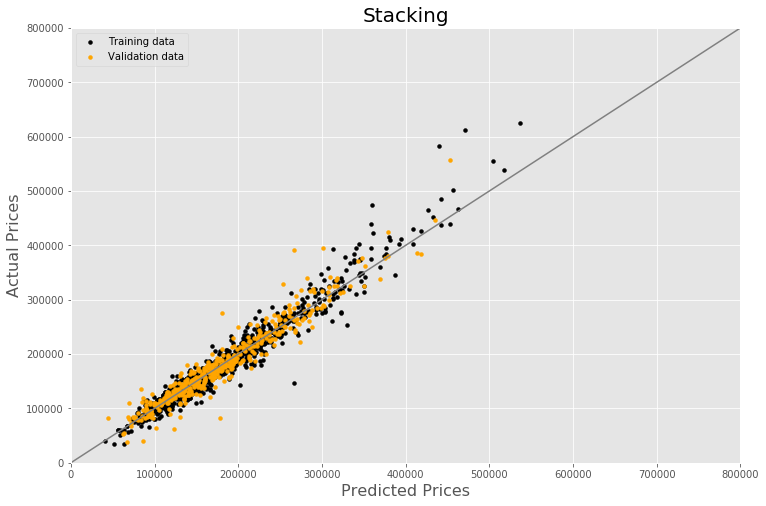

In [370]:
y_test_stack = stackModwAllLas.predict(np.array(X_test))
y_train_las = grid_lasso.predict(X_train)
y_test_las = grid_lasso.predict(X_test)

# Plot predictions
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_train_las), np.expm1(Y_train), c='black', marker="o", s=15, label = "Training data")
plt.scatter(np.expm1(y_test_las), np.expm1(Y_test), c='orange', marker='o', s=15, label = "Validation data")
plt.title("Stacking", fontsize = 20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()

<p><a name="sub"></a></p>

## Submissions

Define file name for import

In [442]:
fNte = "te7"

In [443]:
testDF = pd.read_csv(fNte + '.csv', index_col = 0)

In [243]:
#testDF['YrSoldMinRem'] = testDF['YrSoldMinRem'].fillna(0)

Lasso

In [444]:
Y_pred = grid_lasso.predict(testDF)
Y_pred = np.expm1(Y_pred)
ids = np.arange(1461,2920,1)

In [445]:
predictions = pd.DataFrame({'Id':ids,'SalePrice': Y_pred})

In [446]:
predictions.to_csv('predictlas11.csv', index=False)

In [102]:
#predictTocsv(grid_lasso, 'predictlas3')

C:\Users\tnivo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in expm1
  if __name__ == '__main__':


ValueError: Shape of passed values is (2, 2), indices imply (1459, 2)

Elastic Net

In [184]:
predEnet = grid_eNet.predict(testDF)
predEnet = np.expm1(predEnet)
ids = np.arange(1461,2920,1)
predEnet = pd.DataFrame({'Id':ids,'SalePrice': predEnet})
predEnet.to_csv('predictENet3.csv', index=False)

In [ ]:
predictTocsv(grid_eNet, 'predictENet2')

XGBoost

In [247]:
#Back to csv for kaggle
test_predict = grid_xgb.predict(testDF)
id_price = list(zip(range(1461, 2920), np.expm1(test_predict)))
id_price = list(map(lambda x: [x[0], round(x[1], 1)], id_price))
final_df = pd.DataFrame(id_price, columns=['Id', 'SalePrice'])

Random Forest

In [391]:
test_rForest = grid_rforest.predict(testDF)
test_rForest = np.expm1(test_rForest)
#test_predictions_tuned_rForest2 = grid_search_rForest2.best_estimator_.predict(test)

In [392]:
Ids = np.arange(1461, 2920, 1)
#test_rForest = np.exp(test_rForest) - 1
pred = pd.DataFrame({'Id': Ids,'SalePrice': test_rForest})
#test_rForest
pred.to_csv('predRF2.csv', index = False)

Stacking

In [386]:
#stackModwAllLas
test_stack = stackModwAllLas.predict(np.array(testDF))
test_stack = np.expm1(test_stack)
#test_predictions_tuned_rForest2 = grid_search_rForest2.best_estimator_.predict(test)

In [387]:
Ids = np.arange(1461, 2920, 1)

pred = pd.DataFrame({'Id': Ids,'SalePrice': test_stack})

#pred.to_csv('predStack2.csv', index = False)

In [389]:
pred.to_csv('predStack3.csv', index = False)

In [390]:
test_stack2 = stackModwoRF.predict(np.array(testDF))
test_stack2 = np.expm1(test_stack2)
Ids = np.arange(1461, 2920, 1)
pred = pd.DataFrame({'Id': Ids,'SalePrice': test_stack})
pred.to_csv('predStack4.csv', index = False)

In [251]:
#final_df.to_csv('predictxg.csv', index=False)

In [253]:
#predictTocsv(grid_xgb, testDF,'predictxg1')

In [ ]:
def predictTocsv(modSel, title):
    """
    Function takes selected model and creates CSV file
    Function takes two inputs:
    1. modSel = selected model used to create predictions
    2. title = title for CSV
    """
    pred = modSel.predict(testDF)
    pred = np.expm1(predEnet)
    ids = np.arange(1461,2920,1)
    predEnet = pd.DataFrame({'Id':ids,'SalePrice': pred})
    predEnet.to_csv(title + '.csv', index=False)